In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('./data.csv')
useful_columns = set(list(filter(lambda name: 'mean'  in name, df.columns)) + ['id', 'diagnosis'])
df = df.drop(list(filter(lambda name: name not in useful_columns, df.columns)), 1)
mapper = {"M": 1, 'B':0}

df['diagnosis'] = df['diagnosis'].apply(lambda x: mapper[x])

In [5]:
kmeans_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'smoothness_mean', 'concavity_mean']
kmeans_df = df[['diagnosis'] + kmeans_features]

In [6]:
def getBestKMeans(X, n_clusters, n_trials=10): 
    best_kmeans = None
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    for _ in range(n_trials):
        rnd_seed = np.random.randint(0, 10**6)
        kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=rnd_seed)
        kmeans.fit(X_scaled)
        if best_kmeans is None or kmeans.inertia_ < best_kmeans.inertia_:
            best_kmeans = kmeans
    return best_kmeans       

In [7]:
kmeans = getBestKMeans(kmeans_df.drop(['diagnosis'], 1), 5)

In [27]:
kmeans_df
kmeans_df[kmeans.labels_ == 1] # кластер
feature = kmeans_df[kmeans.labels_ == 1].smoothness_mean.values
len(kmeans_df)

569

In [61]:
def bootstrap_mean(vector):
    """
    input:
    vector: input array to calculate bootstrap
    
    returns: 
    means_array: vector of mean for each iteration
    """
    K = 10000 # number of iterations
    N = 0.6 # procent of array size to take from array to random set 
    
    means_array = []
    
    # Mean computations
    for iter in range(K):
        random_vector = np.random.choice(vector, size = int(N * len(vector)))
        mean = np.mean(random_vector)
        means_array.append(mean)
    return means_array

def bootstrap_pivot(means_array):
    """
    Calculating bootstrap with pivot method.
    input:
    means_array: input array of means
    
    returns: 
    tuple of left boundary and right boundary
    """
    means_mean = np.mean(means)
    means_std = np.std(means)
    
    # Calculate left and right boundary by Gaussian distribution
    left = means_mean - 1.96 * means_std
    right = means_mean + 1.96 * means_std
    return round(left, 6), round(right, 6)


def bootstrap_non_pivot(means_array):
    """
    Calculating bootstrap with non-pivot method.
    input:
    means_array: input array of means
    
    returns: 
    tuple of left boundary and right boundary
    """
    alpha = 0.95 # 1 - alpha level 
    # Calculate left and right boundary by Gaussian distribution throuw quantiles
    left = np.quantile(means_array, 0.5 - alpha / 2)
    right = np.quantile(means_array, 0.5 + alpha / 2)
    
    return round(left, 6), round(right, 6) 

In [62]:
means = bootstrap_mean(vector = kmeans_df.smoothness_mean.values)
pivot_boundaries = bootstrap_pivot(means_array = means)
non_pivot_boundaries = bootstrap_non_pivot(means_array = means)

pivot_boundaries, non_pivot_boundaries

((0.094863, 0.097851), (0.094892, 0.097869))

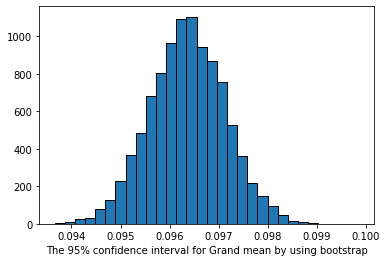

In [59]:
plt.xlabel("The 95% confidence interval for Grand mean by using bootstrap")
plt.hist(means, bins=30, edgecolor='black');
plt.savefig('bootstrap_mean.png')

In [64]:
cluster_1 = kmeans_df[kmeans.labels_ == 0].smoothness_mean.values
cluster_3 = kmeans_df[kmeans.labels_ == 2].smoothness_mean.values

In [65]:
def bootstrap_mean_two_array(vector1, vector2):
    """
    input:
    vector1: first input array to calculate bootstrap
    vector2: second input array to calculate bootstrap
    
    returns: 
    means_array: vector of mean for each iteration
    """
    K = 10000 # number of iterations
    N = 0.6 # procent of array size to take from array to random set 
    
    means_array = []
    common_len = min(len(vector1), len(vector2))
    
    # Mean computations
    for iter in range(K):
        random_vector1 = np.random.choice(vector1, size = int(N * common_len))
        random_vector2 = np.random.choice(vector2, size = int(N * common_len))
        mean = np.mean(random_vector1) - np.mean(random_vector2)
        means_array.append(np.abs(mean))
    return means_array

In [67]:
means = bootstrap_mean_two_array(vector1 = cluster_1, vector2 = cluster_3)
pivot_boundaries = bootstrap_pivot(means_array = means)
non_pivot_boundaries = bootstrap_non_pivot(means_array = means)

pivot_boundaries, non_pivot_boundaries

((0.009428, 0.016933), (0.009414, 0.016958))

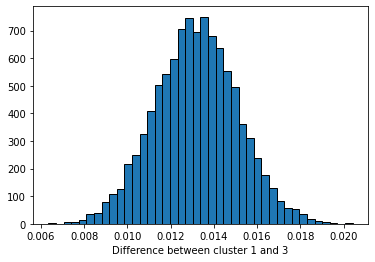

In [68]:
plt.xlabel("Difference between cluster 1 and 3");
plt.hist(means, bins=40, edgecolor='black');
plt.savefig('boot_diference.png')

In [73]:
Grand_mean = np.mean(kmeans_df.smoothness_mean.values)

means = bootstrap_mean(vector = cluster_1 - Grand_mean)
pivot_boundaries = bootstrap_pivot(means_array = means)
non_pivot_boundaries = bootstrap_non_pivot(means_array = means)

pivot_boundaries, non_pivot_boundaries

((-0.013519, -0.008308), (-0.013577, -0.008369))

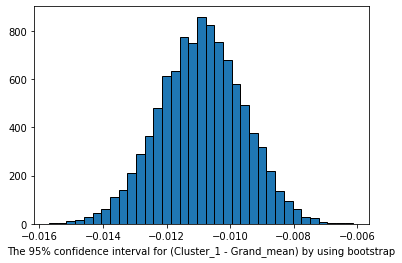

In [75]:
plt.xlabel("The 95% confidence interval for (Cluster_1 - Grand_mean) by using bootstrap")
plt.hist(means, bins=35, edgecolor='black');
plt.savefig('boot_grandmean')